# sequence prediction sandbox


In [1]:
import torch
from torch.utils.data import TensorDataset,DataLoader
from torch import nn

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
random.seed(10)

import utils as u

## Load data 

In [2]:
def load_data(
        upstream_region_file,
        data_mat_file, 
        sample2cond_file, 
        sample_file, 
        condition_file,
        coded_meta_file
        ):
    '''
    Wrapper function to load data from files into relavent objects
    '''
    # load upstream seq regions
    seqs = u.load_promoter_seqs(upstream_region_file)
    loc2seq = dict([(x,z) for (x,y,z) in seqs])
    
    # load TPM data
    tpm_df = pd.read_csv(data_mat_file,sep='\t').fillna('')

    
    # load mapping from sample to condition
    with open(sample2cond_file,'r') as f:
        sample2condition = dict(x.strip().split() for x in f.readlines())

    
    # load sample to include file
    if sample_file:
        with open(sample_file,'r') as f:
            samples = list(x.strip() for x in f.readlines())
    # if none provided, just use all the samples from the sample2condition dict
    else: 
        samples = list(sample2condition.keys())

        
    # load the conditions to include file
    if condition_file:
        with open(condition_file,'r') as f:
            conditions = list(x.strip() for x in f.readlines())
    # if none provided, just use all the conditions
    else:
        conditions = list(set([sample2condition[x] for x in sample2condition]))

    # load coded metadata file
    meta_df = pd.read_csv(coded_meta_file,sep='\t')
    meta_df['sample'] = meta_df['#sample']+'_tpm'

    return loc2seq, tpm_df, sample2condition, samples, conditions, meta_df

In [3]:
upstream_region_file = 'all_seq_info/all_loci_upstream_regions_w100_min20.fa'
data_mat_file = 'data/extract_TPM_counts.tsv'
sample2cond_file = 'data/sample2condition.txt'
sample_file = None
condition_file = 'data/conditions_to_include.txt'
coded_meta_file = 'data/5G_exp_metadata_coded.tsv'
COND_COLS = ['carbon_source','oxygen_level','nitrate_level','copper_level','lanthanum_level','growth_rate','growth_mode']


loc2seq, tpm_df, sample2condition, samples, conditions, meta_df = load_data(
    upstream_region_file,
    data_mat_file, 
    sample2cond_file, 
    sample_file, 
    condition_file,
    coded_meta_file
)

In [4]:
def format_XY_dfs(tpm_df, meta_df):
    # melt tpm df so every sample is in a row
    tpm_melt = tpm_df[['locus_tag']+samples].melt(id_vars=['locus_tag'],var_name='sample',value_name='tpm')
    tpm_melt['condition'] = tpm_melt['sample'].apply(lambda x: sample2condition[x])

    # also add in upstream seq
    tpm_melt['upstream_region'] = tpm_melt['locus_tag'].apply(lambda x: loc2seq[x])
    
    # get coded metadata conditions from meta_df
    samp2cond_df = meta_df[['sample']+COND_COLS]

    # merge back onto the tpm df
    df = tpm_melt.merge(samp2cond_df,on='sample',how='left')
    
    # reformat full df
    full_df = df[['locus_tag','upstream_region', 'sample','condition']+COND_COLS+['tpm']]
    
    # separate out just X (features) and Y (labels)
    X = full_df[['locus_tag','upstream_region']+COND_COLS]
    Y = full_df['tpm']
    
    return full_df,X,Y
    

In [5]:
full_df, X, Y = format_XY_dfs(tpm_df,meta_df)

In [6]:
full_df

,locus_tag,upstream_region,sample,condition,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,tpm
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,2.933003
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.607784
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.415515
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,3.200081
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.522728
...,...,...,...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,24.508375
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,130.851229
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,66.415222
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,5GB1C-JG15-N-BR2_tpm,NoLanthanum,2,1,0,3,0,2,1,164.123473


In [7]:
X

,locus_tag,upstream_region,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,2,0,0,3,0,0,0
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,2,0,0,3,0,0,0
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,2,0,0,3,0,0,0
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,2,0,0,3,0,0,0
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,2,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,2,1,0,3,0,2,1
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,2,1,0,3,0,2,1
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,2,1,0,3,0,2,1
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,2,1,0,3,0,2,1


In [8]:
Y

0           2.933003
1           1.607784
2           1.415515
3           3.200081
4           1.522728
             ...    
412869     24.508375
412870    130.851229
412871     66.415222
412872    164.123473
412873    301.751157
Name: tpm, Length: 412874, dtype: float64

In [9]:
def one_hot_encode(seq):
    #print("one hot encoding...")
    
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Creat empty matrix.
    #vec=torch.tensor([nuc_d[x] for x in seq])
    vec=np.array([nuc_d[x] for x in seq]).flatten()
        
    return vec

## Fake data

In [10]:
data = [
    ('AAAAAA', 10.0),
    ('ATAAAA', 9.0),
    ('AAAACA', 9.8),
    ('CCAACA', 8.0),
    ('CCCCCC', 7.0),
    ('CGGACC', 6.8),
    ('CCCGCC', 6.7),
    ('GGGACG', 6.2),
    ('CGGGCG', 5.0),
    ('GGGGGG', 4.0),
    ('GCCGGT', 4.1),
    ('TGGTGT', 3.0),
    ('CGGTTG', 3.4),
    ('TTGTGT', 2.0),
    ('TTTTTT', 1.0),
    ('TAATTA', 5.1),
    ('GAGTGA', 5.3),
    ('AAATAA', 9.1),
    ('AAAAAG', 9.4),
    ('TTAGCT', 3.2),
    ('CAAAAA', 9.9),
    ('ACAAAA', 9.8),
    ('AAAACA', 9.8),
    ('CCAATA', 7.8),
    ('CCCGCC', 6.8),
    ('CGGATC', 6.6),
    ('CACGCC', 6.9),
    ('AGGACG', 6.5),
    ('CGTGCG', 4.9),
    ('GGGGGA', 4.3),
    ('GCCGGA', 4.5),
    ('TGGTGA', 3.5),
    ('CGGTTA', 3.8),
    ('TTGTGA', 2.5),
    ('TTTTTG', 1.1),
    ('TAATAA', 5.6),
    ('GAGTGC', 5.0),
    ('AAATAC', 8.7),
    ('AACAAA', 9.9),
    ('TTCTTT', 1.3),
    ('TTTCTT', 1.2),
    ('TTTTGT', 1.1),
    ('GTTTTT', 1.1),
    ('AACAAA', 9.8),
    ('AAAAGA', 9.7),
    ('TAAAAA', 9.4),
]
df = pd.DataFrame(data, columns = ['seq','score'])

In [11]:
df['oh'] = df['seq'].apply(lambda x: one_hot_encode(x))

In [12]:
df.values[5]

array(['CGGACC', 6.8,
       array([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0.])], dtype=object)

In [13]:
# train test split
idxs = list(range(df.shape[0]))
random.shuffle(idxs)
print(idxs)

split = int(len(idxs)*0.8)
train_idxs = idxs[:split]
test_idxs = idxs[split:]

print("Train #:", len(train_idxs))
print("Test #:", len(test_idxs))

[21, 41, 32, 18, 26, 15, 24, 40, 6, 22, 3, 38, 42, 16, 35, 28, 5, 14, 8, 9, 25, 12, 43, 19, 4, 39, 1, 11, 23, 7, 34, 20, 37, 33, 44, 10, 17, 31, 29, 13, 0, 45, 30, 27, 2, 36]
Train #: 36
Test #: 10


In [14]:
train_df = df[df.index.isin(train_idxs)]
test_df = df[df.index.isin(test_idxs)]

x_train = torch.tensor(list(train_df['oh'].values))
y_train = torch.tensor(list(train_df['score'].values)).unsqueeze(1)
x_test  = torch.tensor(list(test_df['oh'].values))
y_test  = torch.tensor(list(test_df['score'].values)).unsqueeze(1)

In [15]:
x_test

tensor([[1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,

In [16]:
y_test

tensor([[10.0000],
        [ 9.8000],
        [ 2.0000],
        [ 9.1000],
        [ 6.5000],
        [ 4.3000],
        [ 4.5000],
        [ 3.5000],
        [ 5.0000],
        [ 9.4000]], dtype=torch.float64)

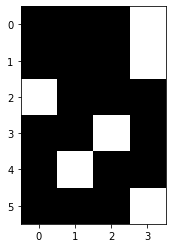

In [17]:
plt.imshow(x_train[15].reshape((6, 4)), cmap="gray")

In [18]:
bs = 4

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs * 2)

In [19]:
for xb, yb in train_dl:
    print(xb)
    print(yb)

tensor([[0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 1., 0., 0., 0.]], dtype=torch.float64)
tensor([[5.6000],
        [4.1000],
        [6.8000],
        [2.5000]], dtype=torch.float64)
tensor([[0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.

In [20]:
class DNA_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(24, 1)

    def forward(self, xb):
        # lin wraps up the weights/bias dot product from before
        return self.lin(xb)

lr = 0.01
epochs = 10
model = DNA_Logistic()
loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [21]:
xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb.float()) 

In [22]:
preds.shape

torch.Size([4, 1])

In [23]:
yb = y_train[:bs]

In [24]:
yb.shape

torch.Size([4, 1])

In [25]:
print(loss_func(preds,yb))

tensor(58.2392, dtype=torch.float64, grad_fn=<MseLossBackward>)


In [26]:
preds.shape

torch.Size([4, 1])

In [27]:
yb.shape

torch.Size([4, 1])

In [28]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb.float()), yb.float())

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit(epochs, model, loss_func, opt, train_dl, test_dl):
    train_losses = []    
    val_losses = []
    for epoch in range(epochs):
        print("TRAIN")
        model.train()
        ts = []
        ns = []
        for xb, yb in train_dl:
            t, n = loss_batch(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
#         losses, nums = zip(
#             # loop through test batches
#             # returns loss calc for test set batch size
#             # unzips into two lists
#             *[loss_batch(model, loss_func, xb, yb) for xb, yb in train_dl]
#         )
#         print("losses", losses)
#         print("nums", nums)
#         train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
#         train_losses.append(train_loss)
#         print(epoch, train_loss)
        
        print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        print("losses", losses)
        print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [29]:
tl, vl = fit(50, model, loss_func, optimizer, train_dl, test_dl)

TRAIN
EVAL
losses (18.75469398498535, 21.69134521484375)
nums (8, 2)
0 19.34202423095703
TRAIN
EVAL
losses (8.681900024414062, 10.339454650878906)
nums (8, 2)
1 9.013410949707032
TRAIN
EVAL
losses (4.36370849609375, 5.328217029571533)
nums (8, 2)
2 4.556610202789306
TRAIN
EVAL
losses (2.430368661880493, 3.0053441524505615)
nums (8, 2)
3 2.545363759994507
TRAIN
EVAL
losses (1.4986082315444946, 1.866747260093689)
nums (8, 2)
4 1.5722360372543336
TRAIN
EVAL
losses (1.0193586349487305, 1.2771519422531128)
nums (8, 2)
5 1.070917296409607
TRAIN
EVAL
losses (0.75172358751297, 0.9639832377433777)
nums (8, 2)
6 0.7941755175590515
TRAIN
EVAL
losses (0.5846325159072876, 0.7489259243011475)
nums (8, 2)
7 0.6174911975860595
TRAIN
EVAL
losses (0.48167771100997925, 0.6272326707839966)
nums (8, 2)
8 0.5107887029647827
TRAIN
EVAL
losses (0.4165768027305603, 0.538201630115509)
nums (8, 2)
9 0.44090176820755006
TRAIN
EVAL
losses (0.3754390776157379, 0.4750153124332428)
nums (8, 2)
10 0.3953543245792389
T

/home/ewilson6/anaconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


EVAL
losses (0.3253081738948822, 0.35731539130210876)
nums (8, 2)
22 0.33170961737632754
TRAIN
EVAL
losses (0.3260495960712433, 0.3666001856327057)
nums (8, 2)
23 0.3341597139835358
TRAIN
EVAL
losses (0.3283992409706116, 0.36898162961006165)
nums (8, 2)
24 0.3365157186985016
TRAIN
EVAL
losses (0.3311214745044708, 0.3722897171974182)
nums (8, 2)
25 0.3393551230430603
TRAIN
EVAL
losses (0.33198291063308716, 0.38056325912475586)
nums (8, 2)
26 0.3416989803314209
TRAIN
EVAL
losses (0.3341617286205292, 0.38324177265167236)
nums (8, 2)
27 0.3439777374267578
TRAIN
EVAL
losses (0.336866557598114, 0.38448822498321533)
nums (8, 2)
28 0.34639089107513427
TRAIN
EVAL
losses (0.3380714952945709, 0.3891933560371399)
nums (8, 2)
29 0.3482958674430847
TRAIN
EVAL
losses (0.34051546454429626, 0.3935700058937073)
nums (8, 2)
30 0.35112637281417847
TRAIN
EVAL
losses (0.3405519723892212, 0.40309929847717285)
nums (8, 2)
31 0.3530614376068115
TRAIN
EVAL
losses (0.3406568765640259, 0.41461947560310364)
nums (

In [30]:
s = torch.tensor(one_hot_encode("TGTAAT"))
model(s.float())

tensor([4.9786], grad_fn=<AddBackward0>)

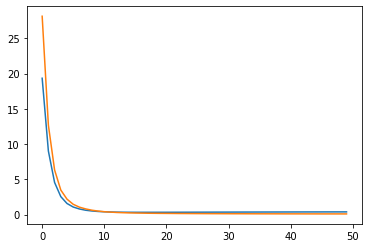

In [33]:
plt.plot(vl)
plt.plot(tl)

In [35]:
for dna in ['AAAAAA', 'CCCCCC','GGGGGG','TTTTTT','AACCAA','CCGGGG','GGGTAA', 'TTTCGT']:
    s = torch.tensor(one_hot_encode(dna))
    pred = model(s.float())
    print(dna, pred)

AAAAAA tensor([10.3558], grad_fn=<AddBackward0>)
CCCCCC tensor([6.5585], grad_fn=<AddBackward0>)
GGGGGG tensor([4.0165], grad_fn=<AddBackward0>)
TTTTTT tensor([0.6569], grad_fn=<AddBackward0>)
AACCAA tensor([8.3212], grad_fn=<AddBackward0>)
CCGGGG tensor([5.1607], grad_fn=<AddBackward0>)
GGGTAA tensor([5.0042], grad_fn=<AddBackward0>)
TTTCGT tensor([1.8137], grad_fn=<AddBackward0>)
